In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
def lennard_jones_potential(r, sigma: float, eps: float) -> np.ndarray:
    return 4*eps*np.power(sigma, 12)/np.power(r, 12) - 4*eps*np.power(sigma, 6)/np.power(r, 6)

def lennard_jones_force(r, sigma: float, eps: float) -> np.ndarray:
    return 24*eps*np.power(sigma, 6)/np.power(r, 7) - 48*eps*np.power(sigma, 12)/np.power(r, 13)

In [112]:
def get_r(x1, y1, x2, y2):
    return np.linalg.norm([x2-x1, y2-y1])

def get_next_x(x, v, a, dt):
    return x + v*dt + a*(dt**2/2)

def get_next_ai(x, xi, r, sigma, eps):
    return lennard_jones_force(r, sigma, eps) * (xi-x)/r

def get_next_v(v, a, a_next, dt):
    return v + (a_next+a)/2*dt

In [113]:
def get_next_x_2d(x, y, vx, vy, ax, ay, dt):
    return get_next_x(x, vx, ax, dt), get_next_x(y, vy, ay, dt)

def get_next_ai_2d(x, y, xi, yi, sigma, eps):
    r = get_r(x, y, xi, yi)
    return get_next_ai(x, xi, r, sigma, eps), get_next_ai(y, yi, r, sigma, eps)

def get_next_a_2d(x, y, xs, ys, sigma, eps):
    sum_x, sum_y = 0, 0
    for i in range(len(xs)):
        _ax, _ay = get_next_ai_2d(x, y, xs[i], ys[i], sigma, eps)
        sum_x += _ax
        sum_y += _ay
    return sum_x, sum_y

def get_next_v_2d(vx, vy, ax, ay, ax_next, ay_next, dt):
    return get_next_v(vx, ax, ax_next, dt), get_next_v(vy, ay, ay_next, dt)

In [114]:
class Particle:
    x: float
    y: float
    vx: float = 0
    vy: float = 0
    ax: float = 0
    ay: float = 0

    _x: float
    _y: float
    _vx: float = 0
    _vy: float = 0
    _ax: float = 0
    _ay: float = 0
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def set_coords(self, x, y):
        self._x = x
        self._y = y

    def set_v(self, vx, vy):
        self._vx = vx
        self._vy = vy

    def set_a(self, ax, ay):
        self._ax = ax
        self._ay = ay
        
    def apply(self):
        self.x = self._x
        self.y = self._y
        self.vx = self._vx
        self.vy = self._vy
        self.ax = self._ax
        self.ay = self._ay
        
    def __repr__(self):
        return f'Particle<x: {self.x}, y: {self.y}, vx: {self.vx}, vy: {self.vy}, ax: {self.ax}, ay: {self.ay}>'

In [138]:
def get_kinetic_energy(particle: Particle):
    return np.power(np.linalg.norm([particle.vx, particle.vy]), 2) / 2

def step_pair(lhs: Particle, rhs: Particle, sigma: float, eps: float, dt: float = 1):
    x, y = get_next_x_2d(lhs.x, lhs.y, lhs.vx, lhs.vy, lhs.ax, lhs.ay, dt)
    ax, ay = get_next_ai_2d(lhs.x, lhs.y, rhs.x, rhs.y, sigma, eps)
    vx, vy = get_next_v_2d(lhs.vx, lhs.vy, lhs.ax, lhs.ay, ax, ay, dt)
    r = get_r(lhs.x, lhs.y, rhs.x, rhs.y)
    
    energy_pot = lennard_jones_potential(r, sigma, eps)
    energy_kin = get_kinetic_energy(lhs)
    
    lhs.set_a(ax, ay)
    lhs.set_v(vx, vy)
    lhs.set_coords(x, y)
    
    return energy_pot, energy_kin

In [142]:
p1 = Particle(100, 100)
p2 = Particle(107, 100)

SIGMA = 1
EPS = 1
STEPS = 200
DT = 1

energy_pot, energy_kin, energy_total, r = [], [], [], []

for i in range(STEPS):
    ep1, ek1 = step_pair(p1, p2, SIGMA, EPS, DT)
    ep2, ek2 = step_pair(p2, p1, SIGMA, EPS, DT)
    
    p1.apply()
    p2.apply()
    
    energy_pot.append(ep1 + ep2)
    energy_kin.append(ek1 + ek2)
    energy_total.append(ep1 + ep2 + ek1 + ek2)
    r.append(get_r(p1.x, p1.y, p2.x, p2.y))

In [143]:
display(p1)
display(p2)

Particle<x: 100.7538751202514, y: 100.0, vx: 0.010483612196654283, vy: 0.0, ax: 0.00015503515837634175, ay: 0.0>

Particle<x: 106.2461248797486, y: 100.0, vx: -0.010483612196654283, vy: 0.0, ax: -0.00015503515837634175, ay: 0.0>

<Axes: >

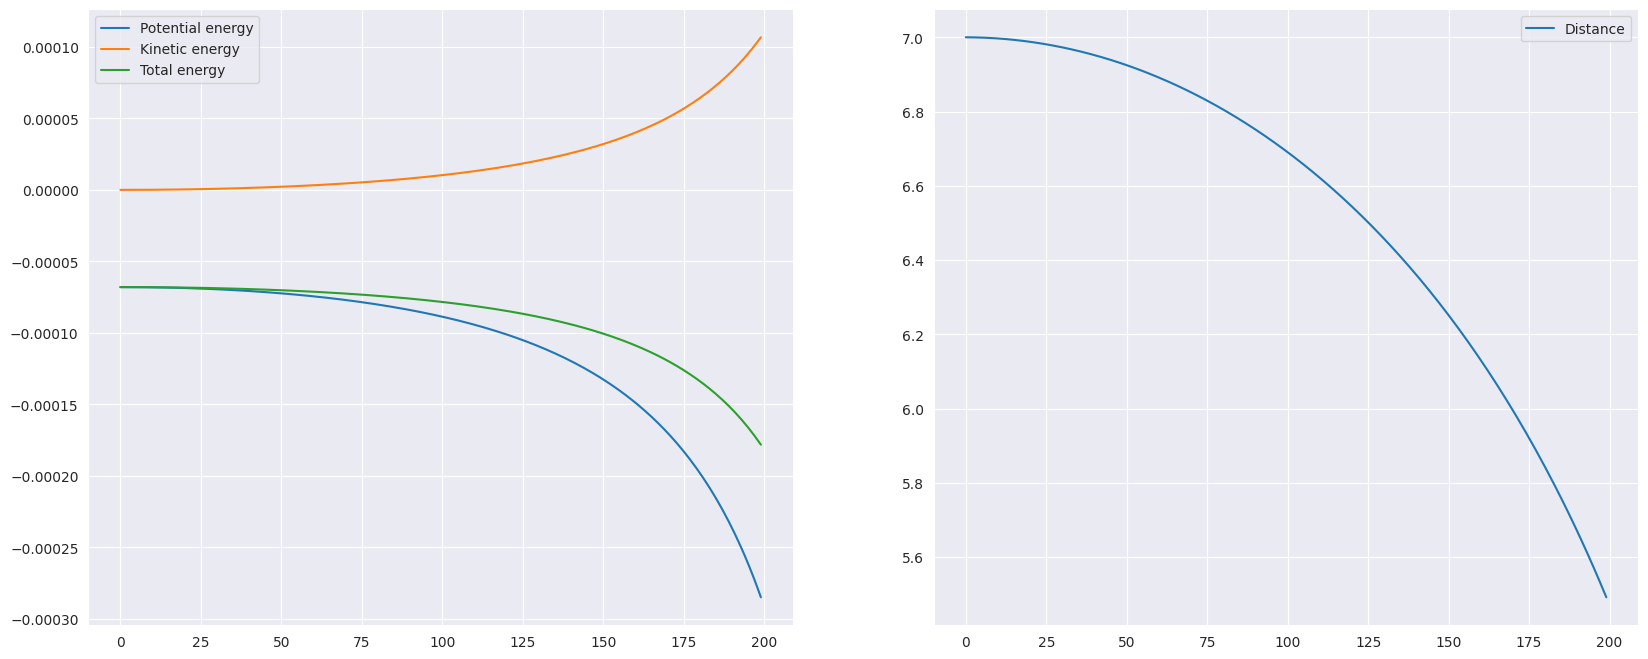

In [144]:
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))
t = np.arange(0, STEPS, 1)

plot = sns.lineplot(
    x=t,
    y=energy_pot,
    ax=axes[0],
    label='Potential energy',
)

sns.lineplot(
    x=t,
    y=energy_kin,
    ax=axes[0],
    label='Kinetic energy',
)

sns.lineplot(
    x=t,
    y=energy_total,
    ax=axes[0],
    label='Total energy',
)

sns.lineplot(
    x=t,
    y=r,
    ax=axes[1],
    label='Distance',
)
# plot.axhline(y=0, color='grey');

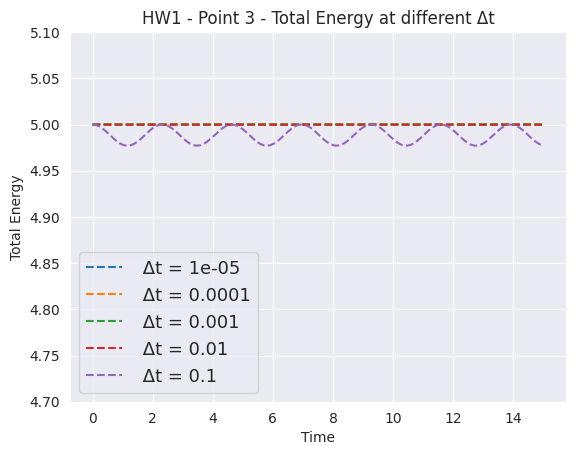

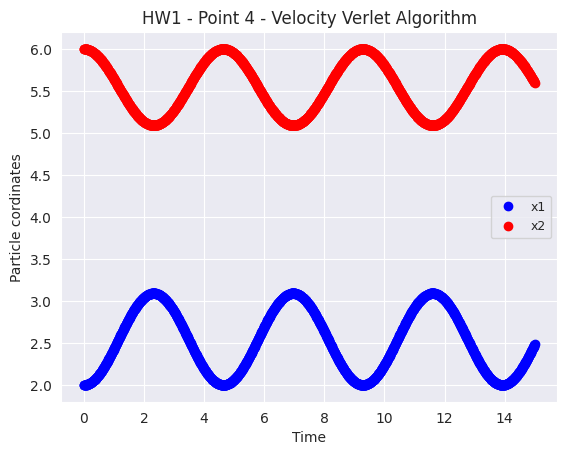

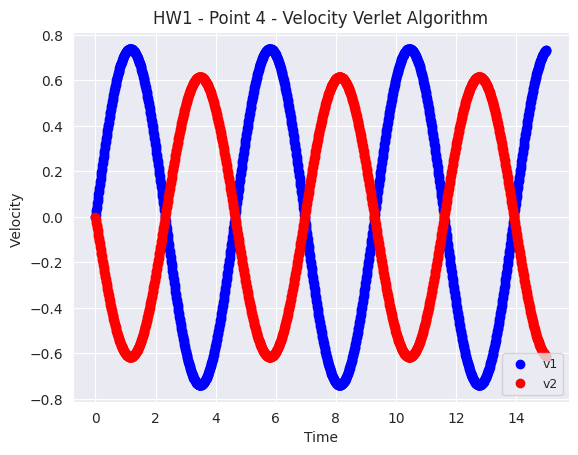

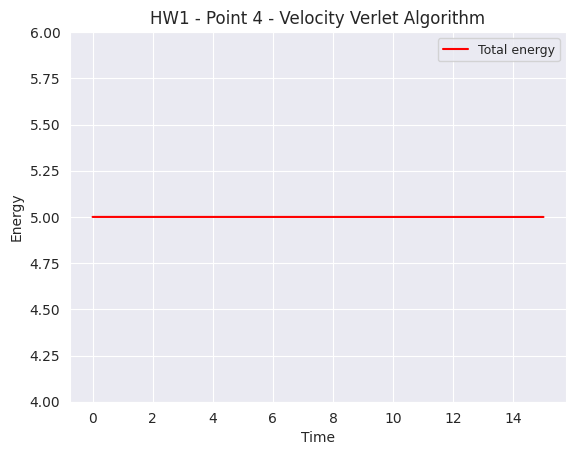

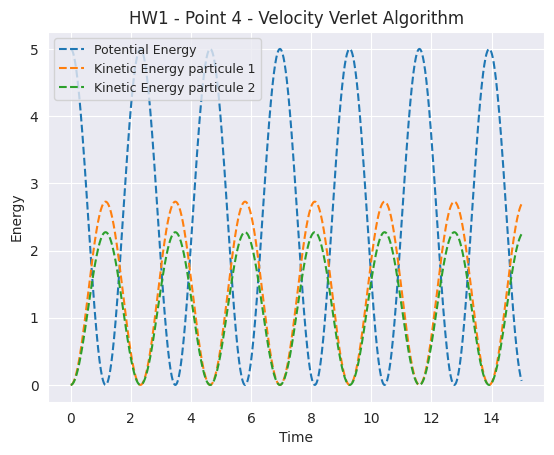

Vibrational frecuency =  5.06177790942404e-12 cm ^-1


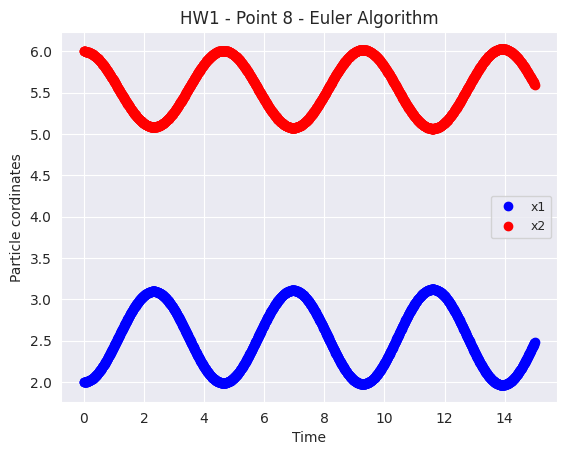

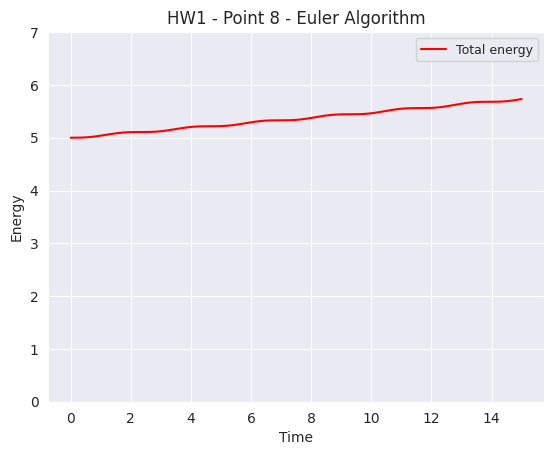

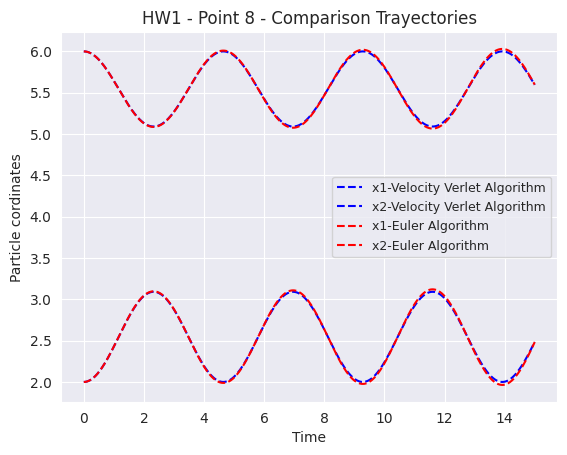

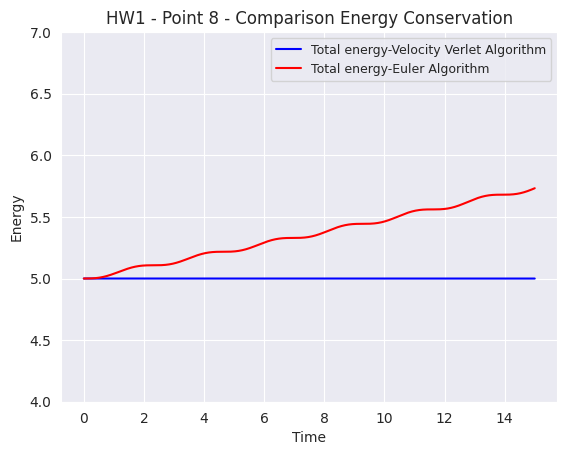

In [163]:
# %% Libraries

import numpy as np
import matplotlib.pyplot as plt
import math

# %% Parameters
k = 10  # erg/cm2
x0 = 3  # cm, it is the equilibrium length of the spring
m1 = 10  # g
m2 = 12  # g
simulation_time = 15

# %% Initial Conditions

x1_0 = 2  # cm
x2_0 = 6  # cm
v1_0 = 0  # cm/s
v2_0 = 0  # cm/s
F_initial = k * (x2_0 - x1_0 - x0)  # g * (cm/s^2)


# %% Velocity Verlet algorithm

def VelocityVerletAlgorithm(simulation_time, dt, x0, x1_0, x2_0, v1_0, v2_0, F_initial):
    time = np.arange(0, simulation_time + dt, dt)

    x1 = [x1_0]
    x2 = [x2_0]
    v1 = [v1_0]
    v2 = [-v2_0]  # the negative sign is because the direction is opposite

    F = [F_initial]
    a1 = [F_initial / m1]
    a2 = [F_initial / m2]

    U = [1/2 * k * (x2[0] - x1[0] - x0)**2]
    energy_kinetic_1 = [1/2 * m1 * v1_0**2]
    energy_kinetic_2 = [1/2 * m2 * v2_0**2]

    total_energy = [(U[0] + energy_kinetic_1[0] + energy_kinetic_2[0])]

    for i in range(len(time) - 1):
        curr = i
        next = i+1
        
        # получим следующие координаты
        x1.append(x1[curr] + v1[curr]*dt + (a1[curr] * dt**2)/2)
        x2.append(x2[curr] + v2[curr]*dt - (a2[curr] * dt**2)/2)

        # получим следующие значения силы и ускорений из следующих координат
        F.append(k * (x2[next] - x1[next] - x0))
        a1.append(F[next] / m1)
        a2.append(F[next] / m2)

        # получим следующие значения скоростей
        v1.append(v1[curr] + ((a1[curr] + a1[next])*dt)/2)
        v2.append(v2[curr] - ((a2[curr] + a2[next])*dt)/2)

        # получим следующее значение потенциала
        U.append(1/2 * k * (x2[next] - x1[next] - x0)**2)

        # получим следующие значения кинетических энергий частиц
        energy_kinetic_1.append(m1 * (v1[next]**2) / 2)
        energy_kinetic_2.append(m2 * (v2[next]**2) / 2)

        total_energy.append(U[next] + energy_kinetic_1[next] + energy_kinetic_2[next])

    return x1, x2, v1, v2, F, time, U, energy_kinetic_1, energy_kinetic_2, total_energy
         # 0   #1  #2  #3  #4  #5   #6        #7                #8              #9


# %% 3)
delta_t_test = [10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 1]

for i in range(len(delta_t_test) - 1):
    total_energy = VelocityVerletAlgorithm(simulation_time, delta_t_test[i], x0, x1_0, x2_0, v1_0, v2_0, F_initial)[9]
    time = VelocityVerletAlgorithm(simulation_time, delta_t_test[i], x0, x1_0, x2_0, v1_0, v2_0, F_initial)[5]
    plt.ylim(4.7, 5.1)  # to set-up depend your result
    plt.plot(time, total_energy, '--', label=" Δt = {}".format(delta_t_test[i]))
    plt.legend(fontsize=13)
    plt.xlabel('Time')
    plt.ylabel('Total Energy')
    plt.title("HW1 - Point 3 - Total Energy at different Δt")
plt.show()

# %% 4) Make plots of the particle coordinates and velocities versus time based on the simulation results.

delta_t = 0.01

x1_verlet = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[0]
x2_verlet = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[1]
v1_verlet = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[2]
v2_verlet = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[3]
time = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[5]

plt.plot(time, x1_verlet, 'o', color='b', label="x1")
plt.plot(time, x2_verlet, 'o', color='r', label="x2")
plt.legend(fontsize=9)
plt.xlabel('Time')
plt.ylabel('Particle cordinates')
plt.title("HW1 - Point 4 - Velocity Verlet Algorithm")
plt.show()

plt.plot(time, v1_verlet, 'o', color='b', label="v1")
plt.plot(time, v2_verlet, 'o', color='r', label="v2")
plt.legend(fontsize=9)
plt.xlabel('Time')
plt.ylabel('Velocity ')
plt.title("HW1 - Point 4 - Velocity Verlet Algorithm")
plt.show()

# %% 5)
total_energy_verlet = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[9]
plt.plot(time, total_energy_verlet, '-', color='red', label="Total energy")
plt.ylim(4, 6)
plt.legend(fontsize=9)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title("HW1 - Point 4 - Velocity Verlet Algorithm")
plt.show()

U_verlet = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[6]
plt.plot(time, U_verlet, '--', label="Potential Energy")
plt.legend(fontsize=9)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title("HW1 - Point 4 - Velocity Verlet Algorithm")

energy_kinetic1_verlet = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[7]
energy_kinetic2_verlet = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[8]
plt.plot(time, energy_kinetic1_verlet, '--', label="Kinetic Energy particule 1")
plt.plot(time, energy_kinetic2_verlet, '--', label="Kinetic Energy particule 2")
plt.legend(fontsize=9)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title("HW1 - Point 4 - Velocity Verlet Algorithm")
plt.show()

# %% 6)

# For time steps greater than 1 the vibrational frequency is not uniform and decrease,
# moreover, the plot shape starts to have distortions and is not uniform.
# For small stiffness of the spring the frequency decrease considerably compared with high values,
# additionally for bigger stiffness of the spring, the amplitude of the wave increase through time.

# %% 7)
velocity_light = 29979245800  # cm/s
reduced_mass = (m1 + m2) / 2  # g
vibrational_frecuency = 1 / (velocity_light * 2 * math.pi) * math.sqrt(k / reduced_mass)
print('Vibrational frecuency = ', vibrational_frecuency, 'cm ^-1')


# The analitycal result is simillar with the frecuency of the figures.

# %% 8)

def Euler_Algorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial):
    time = np.arange(0, simulation_time + delta_t, delta_t)

    x1 = [x1_0]
    x2 = [x2_0]
    v1 = [v1_0]
    v2 = [-v2_0]

    F = [F_initial]

    U = [(1 / 2) * k * (x2[0] - x1[0] - x0) ** 2]
    energy_kinetic_1 = [(1 / 2) * m1 * (v1_0) ** 2]
    energy_kinetic_2 = [(1 / 2) * m2 * (v2_0) ** 2]

    total_energy = [(U[0] + energy_kinetic_1[0] + energy_kinetic_2[0])]

    for i in range(len(time) - 1):
        x1.append(x1[i] + delta_t * v1[i] + delta_t ** 2 * F[i] / (2 * m1))
        x2.append(x2[i] + delta_t * v2[i] - delta_t ** 2 * F[i] / (2 * m2))

        F.append(k * (x2[i + 1] - x1[i + 1] - x0))

        v1.append(v1[i] + (delta_t * (F[i] / (m1))))
        v2.append(v2[i] - (delta_t * (F[i] / (m2))))

        U.append((1 / 2) * k * (x2[i + 1] - x1[i + 1] - x0) ** 2)
        energy_kinetic_1.append((1 / 2) * m1 * (v1[i + 1]) ** 2)
        energy_kinetic_2.append((1 / 2) * m2 * (v2[i + 1]) ** 2)

        total_energy.append(U[i + 1] + energy_kinetic_1[i + 1] + energy_kinetic_2[i + 1])

    return x1, x2, v1, v2, F, time, U, energy_kinetic_1, energy_kinetic_2, total_energy
    # 0  #1  #2  #3  #4  #5  #6       #7                #8               #9


x1_euler = Euler_Algorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[0]
x2_euler = Euler_Algorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[1]

plt.plot(time, x1_euler, 'o', color='b', label="x1")
plt.plot(time, x2_euler, 'o', color='r', label="x2")
plt.legend(fontsize=9)
plt.xlabel('Time')
plt.ylabel('Particle cordinates')
plt.title("HW1 - Point 8 - Euler Algorithm")
plt.show()

total_energy_euler = Euler_Algorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[9]
plt.ylim(0, 7)
plt.plot(time, total_energy_euler, '-', color='red', label="Total energy")
plt.legend(fontsize=9)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title("HW1 - Point 8 - Euler Algorithm")
plt.show()

# %% Comparation

plt.plot(time, x1_verlet, '--', color='b', label="x1-Velocity Verlet Algorithm")
plt.plot(time, x2_verlet, '--', color='b', label="x2-Velocity Verlet Algorithm")
plt.plot(time, x1_euler, '--', color='r', label="x1-Euler Algorithm")
plt.plot(time, x2_euler, '--', color='r', label="x2-Euler Algorithm")
plt.legend(fontsize=9)
plt.xlabel('Time')
plt.ylabel('Particle cordinates')
plt.title("HW1 - Point 8 - Comparison Trayectories")
plt.show()

total_energy_verlet = VelocityVerletAlgorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[9]
total_energy_euler = Euler_Algorithm(simulation_time, delta_t, x0, x1_0, x2_0, v1_0, v2_0, F_initial)[9]
plt.plot(time, total_energy_verlet, '-', color='b', label="Total energy-Velocity Verlet Algorithm")
plt.plot(time, total_energy_euler, '-', color='r', label="Total energy-Euler Algorithm")
plt.ylim(4, 7)
plt.legend(fontsize=9)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title("HW1 - Point 8 - Comparison Energy Conservation")
plt.show()
